# WIP: Pseudo-Soros Attack

<b>This notebook is still a work in progress</b>

## Summary

The pseudo-soros attack experiments mocks up what a hypothetical exploit on the system could be. While the RBS is meant to improve resilience, could someone exploit it?

## Experimental Set Up

- The experiment uses the psub_scenario_option of "Soros" which has additional PSUBs for a large whale in the system being able to make large movements.
- At the timestep of soros_short_timing, the whale will take a short position of soros_short_amount which will hit the system as a net outflow (soros_short_amount * current_price)
- At the soros_close_out_timing, the whale first closes out the short position net the long position. If the long position is larger then there is a net outflow, otherwise it is a net inflow from closing the position.
- The total revenue is measured for each simulation.
- There is a baseline version where soros_short_timing is None meaning the whale is just going to sell all of their OHM at soros_close_out_timing. The success metric is based on whether separate simulations actually earn less than this baseline amount (meaning the exploiter would have been better off not trying to exploit).

## Experiment Specific Parameters

- soros_short_amount: The amount that the whale will go short at the timestep of soros_short_timing.
- soros_short_timing: The timestep the whale goes short
- soros_close_out_timing: The timestep where the whale will both close out its short position (first with any position they might have had in general) and then if they have any leftover long position they will dump at this timestep as well.
- soros_long_position: The long position of OHM at the start of the simulation


## RBS Sweep Parameters
- lower_wall
- upper_wall
- lower_cushion
- upper_cushion

In [27]:
from IPython.display import display
from model.utility.default_parameters import default_params_soros as params
from model.utility.default_initial_state import default_initial_soros as initial_state
from model.utility.initial_state_functions import fill_in_initial_state
from model.run import load_config, run, post_processing


params['soros_short_amount'] = [0, 250000, 500000, 750000, 1000000] * 2
params['soros_short_timing'] = [None, 50, 50, 50, 50]* 2
params['soros_close_out_timing'] = [55, 55, 55, 55, 55]* 2
params['soros_long_position'] = [500000, 500000, 500000, 500000, 500000]* 2

params["lower_wall"] = [.15] * 5 + [.3] * 5
params["upper_wall"] = [.15] * 5 + [.3] * 5
params["lower_cushion"] = [.075] * 5 + [.15] * 5
params["upper_cushion"] = [.075] * 5 + [.15] * 5

# Fill in initial state
initial_state = fill_in_initial_state(initial_state, params)

# Set the params for runs and timesteps
number_runs = 10
number_steps = 100

# Load the experiment
exp = load_config(number_runs, params, initial_state, number_steps,
                 psub_scenario_option = "Soros")

# Run the experiment
raw = run(exp)

# Parse the raw data
df = post_processing(raw)

AssertionError: 

In [ ]:
mapping = {'soros_short_amount': {},
          'soros_short_timing': {},
          "soros_close_out_timing": {},
          "soros_long_position": {}}


for i, x in enumerate(params['soros_short_amount']):
    mapping["soros_short_amount"][i] = x

for i, x in enumerate(params['soros_short_timing']):
    mapping["soros_short_timing"][i] = x
    
for i, x in enumerate(params['soros_close_out_timing']):
    mapping["soros_close_out_timing"][i] = x
    
for i, x in enumerate(params['soros_long_position']):
    mapping["soros_long_position"][i] = x
    
df["soros_short_amount"] = df['subset'].map(mapping['soros_short_amount'])
df["soros_short_timing"] = df['subset'].map(mapping['soros_short_timing'])
df["soros_close_out_timing"] = df['subset'].map(mapping['soros_close_out_timing'])
df["soros_long_position"] = df['subset'].map(mapping['soros_long_position'])

In [ ]:
df.to_csv("soros_runs.csv")

In [1]:
import pandas as pd
df = pd.read_csv("soros_runs.csv", index_col=0)

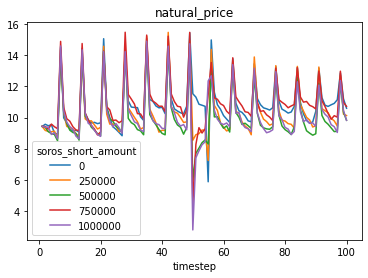

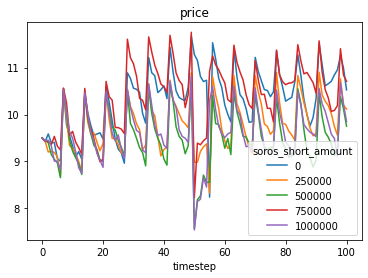

<function matplotlib.pyplot.figure(num=None, figsize=None, dpi=None, facecolor=None, edgecolor=None, frameon=True, FigureClass=<class 'matplotlib.figure.Figure'>, clear=False, **kwargs)>

In [3]:
# Plot the average values for natural price by the groups of supply and demand factor
from model.utility.visualization import plot_all_sims, plot_grouped_variables_average

variables_to_plot = ["natural_price", "price"]
grouping_variables = ["soros_short_amount"]

plot_grouped_variables_average(variables_to_plot,
                               grouping_variables,
                               df)

In [6]:
baseline = df[df["soros_short_amount"] == 0].copy()
df = df[df["soros_short_amount"] != 0].copy()

In [12]:
baseline_revenue = baseline.groupby("unique_id")["soros_revenue"].sum().mean()

In [13]:
revenue = df.groupby("unique_id")[["soros_revenue"]].sum()
descriptors = df.groupby("unique_id")[['soros_short_amount',
 'soros_short_timing',
 'soros_close_out_timing',
 'soros_long_position']].last()
kpis = pd.concat([revenue, descriptors], axis=1)

In [14]:
success_metrics = kpis.copy()

In [24]:
# True means there was not a greater profit by doing the exploit
success_metrics['no_exploit_benefit'] = (success_metrics['soros_revenue'] < baseline_revenue).astype(int)
success_metrics.drop(columns = "soros_revenue", inplace=True)

In [25]:
success_metrics

,soros_short_amount,soros_short_timing,soros_close_out_timing,soros_long_position,no_exploit_benefit
unique_id,,,,,
0-1-1,250000,50.0,55,500000,1
0-1-10,250000,50.0,55,500000,1
0-1-2,250000,50.0,55,500000,1
0-1-3,250000,50.0,55,500000,1
0-1-4,250000,50.0,55,500000,1
...,...,...,...,...,...
0-9-5,1000000,50.0,55,500000,1
0-9-6,1000000,50.0,55,500000,1
0-9-7,1000000,50.0,55,500000,1
